<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Inference_for_finetuned_model_gemma_and_convert_to_gguf_format.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install -q -U bitsandbytes==0.42.0
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10
!pip3 install -q -U accelerate==0.27.1
!pip3 install -q -U datasets==2.17.0
!pip3 install -q -U transformers==4.38.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 58.6 MB/s eta 0:00:00


In [ ]:
from peft import LoraConfig,PeftModel,AutoPeftModelForCausalLM
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
#set the LoRA configurations
peft_config =LoraConfig(
    r=64,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
#
peft_model_id = "Plaban81/gemma-medical_qa-Finetune"
config = peft_config.from_pretrained(peft_model_id)
#
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                             return_dict=True,
                                             load_in_4bit=True,
                                             device_map="auto",
                                             )

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
ptokenizer= AutoTokenizer.from_pretrained(peft_model_id)

tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

In [ ]:
def get_completion(query: str, model, tokenizer) -> str:
  device = "cuda:0"

  prompt_template = """
  <start_of_turn>user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  {query}
  <end_of_turn>\n<start_of_turn>model


  """
  prompt = prompt_template.format(query=query)

  encodeds = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)

  model_inputs = encodeds.to(device)


  generated_ids = model.generate(**model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
  # decoded = tokenizer.batch_decode(generated_ids)
  decoded = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
  return (decoded)

In [ ]:
query = """Please answer with one of the option in the bracket. Write reasoning in between <analysis></analysis>. Write answer in between <answer></answer>.here are the inputs:Q:A 34-year-old man presents to a clinic with complaints of abdominal discomfort and blood in the urine for 2 days. He has had similar abdominal discomfort during the past 5 years, although he does not remember passing blood in the urine. He has had hypertension for the past 2 years, for which he has been prescribed medication. There is no history of weight loss, skin rashes, joint pain, vomiting, change in bowel habits, and smoking. On physical examination, there are ballotable flank masses bilaterally. The bowel sounds are normal. Renal function tests are as follows:\nUrea 50 mg/dL\nCreatinine 1.4 mg/dL\nProtein Negative\nRBC Numerous\nThe patient underwent ultrasonography of the abdomen, which revealed enlarged kidneys and multiple anechoic cysts with well-defined walls. A CT scan confirmed the presence of multiple cysts in the kidneys. What is the most likely diagnosis?? \n{'A': 'Autosomal dominant polycystic kidney disease (ADPKD)', 'B': 'Autosomal recessive polycystic kidney disease (ARPKD)', 'C': 'Medullary cystic disease', 'D': 'Simple renal cysts', 'E': 'Acquired cystic kidney disease'}"""
result = get_completion(query=query, model=model, tokenizer=ptokenizer)
print(f"Model Answer : \n {result.split('model')[-1]}")

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


Model Answer : 
 
  

  <Answer:A> The most likely diagnosis is **'Autosomal dominant polycystic kidney disease (ADPKD)'.**

<Analysis>:
In ADPKD, an abnormal gene mutation is responsible for the excessive growth of fluid-filled cysts in the kidneys. These cysts can be detected through various imaging techniques, including ultrasound, CT scan, and MRI. The presence of multiple renal cysts and enlarged kidneys is characteristic of ADPKD.


In [ ]:
print(result)


  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  Please answer with one of the option in the bracket. Write reasoning in between <analysis></analysis>. Write answer in between <answer></answer>.here are the inputs:Q:A 34-year-old man presents to a clinic with complaints of abdominal discomfort and blood in the urine for 2 days. He has had similar abdominal discomfort during the past 5 years, although he does not remember passing blood in the urine. He has had hypertension for the past 2 years, for which he has been prescribed medication. There is no history of weight loss, skin rashes, joint pain, vomiting, change in bowel habits, and smoking. On physical examination, there are ballotable flank masses bilaterally. The bowel sounds are normal. Renal function tests are as follows:
Urea 50 mg/dL
Creatinine 1.4 mg/dL
Protein Negative
RBC Numerous
The patient underwent ultrasonography of the abdomen, which revealed enlarge

In [ ]:
query = """Please answer with one of the option in the bracket. Write reasoning in between <analysis></analysis>. Write answer in between <answer></answer>. here are the inputs Q:An 8-year-old boy is brought to the pediatrician by his mother with nausea, vomiting, and decreased frequency of urination. He has acute lymphoblastic leukemia for which he received the 1st dose of chemotherapy 5 days ago. His leukocyte count was 60,000/mm3 before starting chemotherapy. The vital signs include: pulse 110/min, temperature 37.0°C (98.6°F), and blood pressure 100/70 mm Hg. The physical examination shows bilateral pedal edema. Which of the following serum studies and urinalysis findings will be helpful in confirming the diagnosis of this condition? ? \n{'A': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, and extremely elevated creatine kinase (MM)', 'B': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, hyperuricemia, urine supernatant pink, and positive for heme', 'C': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and urate crystals in the urine', 'D': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, and urinary monoclonal spike', 'E': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and oxalate crystals'}"""

result = get_completion(query=query, model=model, tokenizer=ptokenizer)
print(result)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  Please answer with one of the option in the bracket. Write reasoning in between <analysis></analysis>. Write answer in between <answer></answer>. here are the inputs Q:An 8-year-old boy is brought to the pediatrician by his mother with nausea, vomiting, and decreased frequency of urination. He has acute lymphoblastic leukemia for which he received the 1st dose of chemotherapy 5 days ago. His leukocyte count was 60,000/mm3 before starting chemotherapy. The vital signs include: pulse 110/min, temperature 37.0°C (98.6°F), and blood pressure 100/70 mm Hg. The physical examination shows bilateral pedal edema. Which of the following serum studies and urinalysis findings will be helpful in confirming the diagnosis of this condition? ? 
{'A': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, and extremely elevated creatine kinase (MM)', 'B': 'Hyperkalemia, hyperphosphatemia, hypo

In [ ]:
query = """Q:An 8-year-old boy is brought to the pediatrician by his mother with nausea, vomiting, and decreased frequency of urination. He has acute lymphoblastic leukemia for which he received the 1st dose of chemotherapy 5 days ago. His leukocyte count was 60,000/mm3 before starting chemotherapy. The vital signs include: pulse 110/min, temperature 37.0°C (98.6°F), and blood pressure 100/70 mm Hg. The physical examination shows bilateral pedal edema. Which of the following serum studies and urinalysis findings will be helpful in confirming the diagnosis of this condition? ? \n{'A': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, and extremely elevated creatine kinase (MM)', 'B': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, hyperuricemia, urine supernatant pink, and positive for heme', 'C': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and urate crystals in the urine', 'D': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, and urinary monoclonal spike', 'E': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and oxalate crystals'}"""

result = get_completion(query=query, model=model, tokenizer=ptokenizer)
print(result)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



  user
  Below is an instruction that describes a task. Write a response that appropriately completes the request.
  Q:An 8-year-old boy is brought to the pediatrician by his mother with nausea, vomiting, and decreased frequency of urination. He has acute lymphoblastic leukemia for which he received the 1st dose of chemotherapy 5 days ago. His leukocyte count was 60,000/mm3 before starting chemotherapy. The vital signs include: pulse 110/min, temperature 37.0°C (98.6°F), and blood pressure 100/70 mm Hg. The physical examination shows bilateral pedal edema. Which of the following serum studies and urinalysis findings will be helpful in confirming the diagnosis of this condition? ? 
{'A': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, and extremely elevated creatine kinase (MM)', 'B': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, hyperuricemia, urine supernatant pink, and positive for heme', 'C': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and urate crystals in 

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
  return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!git clone https://github.com/ggerganov/llama.cpp


Cloning into 'llama.cpp'...
remote: Enumerating objects: 19918, done.
remote: Counting objects: 100% (12135/12135), done.
remote: Compressing objects: 100% (746/746), done.
remote: Total 19918 (delta 11711), reused 11419 (delta 11387), pack-reused 7783
Receiving objects: 100% (19918/19918), 20.42 MiB | 6.89 MiB/s, done.
Resolving deltas: 100% (14270/14270), done.


In [ ]:
!cd llama.cpp && LLAMA_CUBLAS=1 make && pip install -r requirements/requirements-convert-hf-to-gguf.txt


I ccache not found. Consider installing it for faster compilation.
I llama.cpp build info: 
I UNAME_S:   Linux
I UNAME_P:   x86_64
I UNAME_M:   x86_64
I CFLAGS:    -I. -Icommon -D_XOPEN_SOURCE=600 -D_GNU_SOURCE -DNDEBUG -DGGML_USE_CUBLAS -I/usr/local/cuda/include -I/usr/local/cuda/targets/x86_64-linux/include  -std=c11   -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wshadow -Wstrict-prototypes -Wpointer-arith -Wmissing-prototypes -Werror=implicit-int -Werror=implicit-function-declaration -pthread -march=native -mtune=native -Wdouble-promotion 
I CXXFLAGS:  -std=c++11 -fPIC -O3 -Wall -Wextra -Wpedantic -Wcast-qual -Wno-unused-function -Wmissing-declarations -Wmissing-noreturn -pthread  -march=native -mtune=native -Wno-array-bounds -Wno-format-truncation -Wextra-semi -I. -Icommon -D_XOPEN_SOURCE=600 -D_GNU_SOURCE -DNDEBUG -DGGML_USE_CUBLAS -I/usr/local/cuda/include -I/usr/local/cuda/targets/x86_64-linux/include 
I NVCCFLAGS: -std=c++11 -O3 -use_fast_math --forward-

In [ ]:
from huggingface_hub import snapshot_download
model_name = "Plaban81/gemma-medical_qa-Finetune"
methods = ['q4_k_m']
base_model = "./original_model/"
quantized_path = "./quantized_model/"
#
snapshot_download(repo_id=model_name, local_dir=base_model , local_dir_use_symlinks=False)
original_model = quantized_path+'/FP16.gguf'

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

In [ ]:
!mkdir ./quantized_model/

In [ ]:
!python llama.cpp/convert-hf-to-gguf.py ./original_model/ --outtype f16 --outfile ./quantized_model/FP16.gguf


Loading model: original_model
gguf: This GGUF file is for Little Endian only
Set model parameters
Set model tokenizer
gguf: Setting special token type bos to 2
gguf: Setting special token type eos to 1
gguf: Setting special token type unk to 3
gguf: Setting special token type pad to 1
gguf: Setting add_bos_token to True
gguf: Setting add_eos_token to True
gguf: Setting chat_template to {{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '
' + message['content'] | trim + '<end_of_turn>
' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model
'}}{% endif %}
Exporting model to 

## Quantize the finetuned model to 4bit qunatization format

In [ ]:
import os
for m in methods:
  qtype = f"{quantized_path}/{m.upper()}.gguf"
  os.system("./llama.cpp/quantize "+quantized_path+"/FP16.gguf "+qtype+" "+m)

In [ ]:
! ./llama.cpp/main -m ./quantized_model/Q4_K_M.gguf -n 90 --repeat_penalty 1.0 --color -i -r "User:" -f llama.cpp/prompts/chat-with-bob.txt


Log start
main: build = 2355 (e04e04f8)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: seed  = 1709783565
ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA A100-SXM4-40GB, compute capability 8.0, VMM: yes
llama_model_loader: loaded meta data with 24 key-value pairs and 164 tensors from ./quantized_model/Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma
llama_model_loader: - kv   1:                               general.name str              = original_model
llama_model_loader: - kv   2:                       gemma.context_length u32              = 8192
llama_model_loader: - kv   3:                     gemma.embedding_length u32              = 2048
llama_model_loader: - k

## Login to your HF Dashboard

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Set up the required model path and create HF repo

In [ ]:
from huggingface_hub import HfApi, HfFolder, create_repo, upload_file
model_path = "./quantized_model/Q4_K_M.gguf" # Your model's local path
repo_name = "gemma-medical_qa-GGUF"  # Desired HF Hub repository name
repo_url = create_repo(repo_name, private=False)
#



## Upload the quantized model to Huggingface

In [ ]:
api = HfApi()
api.upload_file(
    path_or_fileobj=model_path,
    path_in_repo="Q4_K_M.gguf",
    repo_id="Plaban81/gemma-medical_qa-GGUF",
    repo_type="model",
)


Q4_K_M.gguf:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Plaban81/gemma-medical_qa-GGUF/commit/811ba25102252c4ab1a5739ad5cc9d06a55a9b82', commit_message='Upload Q4_K_M.gguf with huggingface_hub', commit_description='', oid='811ba25102252c4ab1a5739ad5cc9d06a55a9b82', pr_url=None, pr_revision=None, pr_num=None)

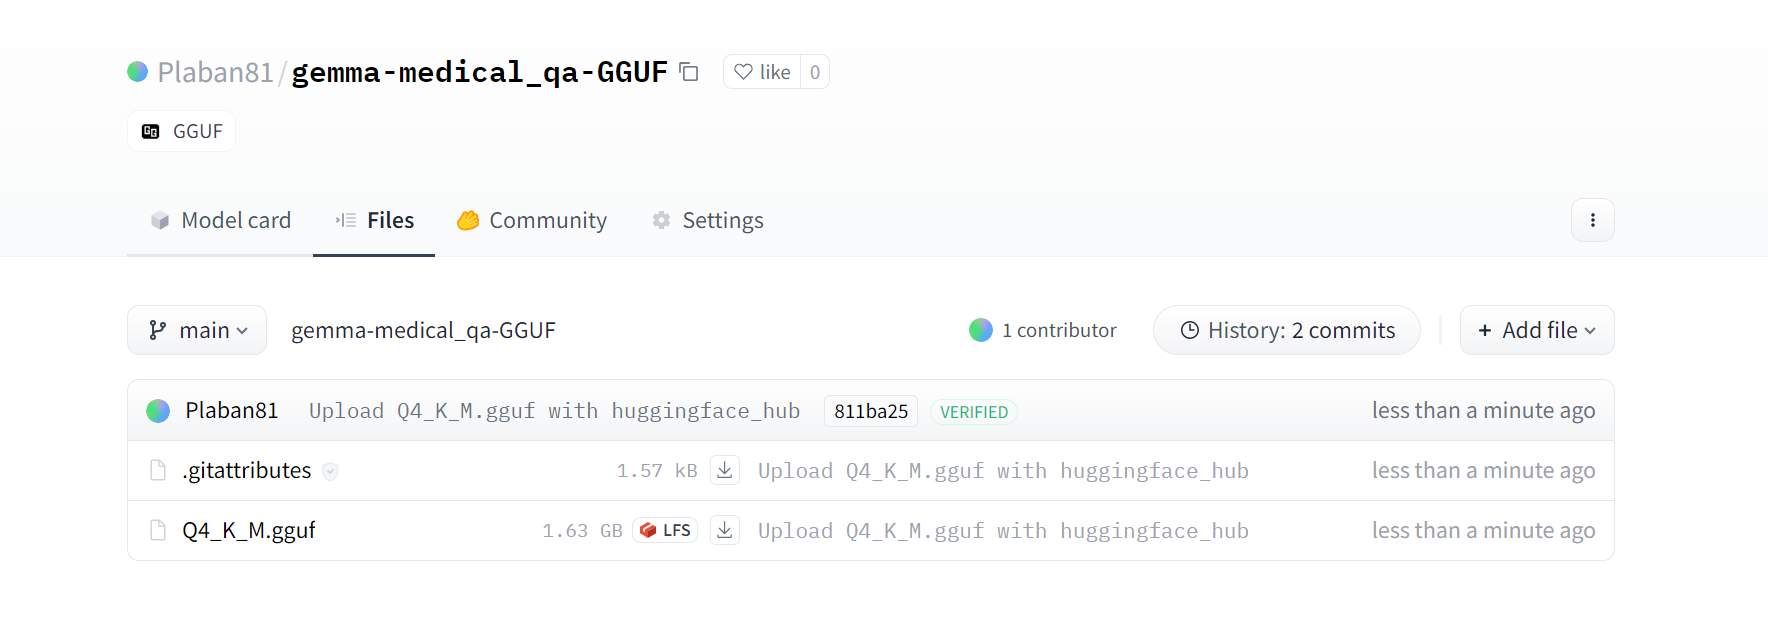

### Download the quantized model for inference

In [ ]:
!wget "https://huggingface.co/Plaban81/gemma-medical_qa-GGUF/resolve/main/Q4_K_M.gguf"

--2024-03-07 04:05:35--  https://huggingface.co/Plaban81/gemma-medical_qa-GGUF/resolve/main/Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 13.33.33.55, 13.33.33.20, 13.33.33.110, ...
Connecting to huggingface.co (huggingface.co)|13.33.33.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/20/d5/20d57fba23807719d4e8961de3105d1634682c63854f594a19c8a8bc6b5a55bb/ed2aa9b3df48b31ae1a4639dea329640eb32491422ac275ab632fe80542227f9?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27Q4_K_M.gguf%3B+filename%3D%22Q4_K_M.gguf%22%3B&Expires=1710043535&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMDA0MzUzNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzIwL2Q1LzIwZDU3ZmJhMjM4MDc3MTlkNGU4OTYxZGUzMTA1ZDE2MzQ2ODJjNjM4NTRmNTk0YTE5YzhhOGJjNmI1YTU1YmIvZWQyYWE5YjNkZjQ4YjMxYWUxYTQ2MzlkZWEzMjk2NDBlYjMyNDkxNDIyYWMyNzVhYjYzMmZlODA1NDIyMjdmOT9yZ

## Install llama-cpp.python on GPU

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 46.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.7 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.55-cp310-cp310-manylinux_2_35_x86_64.whl size=26100945 sha256=a0d76e6c28b573d865a770f1ee19e4d215c10f9b275ed78940de5391cf4cbed7
  Stored in directory: /root/.cache/pip/wheels/35/c9/bb/019dbfeef119ab5c29f76574b76070afa7b7755ccfbb3ee226
Successfully built llama-cpp-python


## use the GGUF model for inferencing

In [ ]:
from llama_cpp import Llama

# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
llm = Llama(
  model_path="/content/Q4_K_M.gguf",  # Download the model file first
  n_ctx=32768,  # The max sequence length to use - note that longer sequence lengths require much more resources
  n_threads=1,            # The number of CPU threads to use, tailor to your system and the resulting performance
  n_gpu_layers=-1         # The number of layers to offload to GPU, if you have GPU acceleration available
)



llama_model_loader: loaded meta data with 24 key-value pairs and 164 tensors from /content/Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma
llama_model_loader: - kv   1:                               general.name str              = original_model
llama_model_loader: - kv   2:                       gemma.context_length u32              = 8192
llama_model_loader: - kv   3:                     gemma.embedding_length u32              = 2048
llama_model_loader: - kv   4:                          gemma.block_count u32              = 18
llama_model_loader: - kv   5:                  gemma.feed_forward_length u32              = 16384
llama_model_loader: - kv   6:                 gemma.attention.head_count u32              = 8
llama_model_loader: - kv   7:              gemma.attention.head_count_kv u32          

## query 1

In [ ]:
query = """Please answer with one of the option in the bracket. Write reasoning in between <analysis></analysis>. Write answer in between <answer></answer>. here are the inputs Q:An 8-year-old boy is brought to the pediatrician by his mother with nausea, vomiting, and decreased frequency of urination. He has acute lymphoblastic leukemia for which he received the 1st dose of chemotherapy 5 days ago. His leukocyte count was 60,000/mm3 before starting chemotherapy. The vital signs include: pulse 110/min, temperature 37.0°C (98.6°F), and blood pressure 100/70 mm Hg. The physical examination shows bilateral pedal edema. Which of the following serum studies and urinalysis findings will be helpful in confirming the diagnosis of this condition? ? \n{'A': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, and extremely elevated creatine kinase (MM)', 'B': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, hyperuricemia, urine supernatant pink, and positive for heme', 'C': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and urate crystals in the urine', 'D': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, and urinary monoclonal spike', 'E': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and oxalate crystals'}"""
output = llm(
  prompt=query,
  max_tokens=512,  # Generate up to 512 tokens
)


llama_print_timings:        load time =   10466.22 ms
llama_print_timings:      sample time =    2082.35 ms /   512 runs   (    4.07 ms per token,   245.88 tokens per second)
llama_print_timings: prompt eval time =   10465.58 ms /   304 tokens (   34.43 ms per token,    29.05 tokens per second)
llama_print_timings:        eval time =    3238.54 ms /   511 runs   (    6.34 ms per token,   157.79 tokens per second)
llama_print_timings:       total time =   26204.66 ms /   815 tokens


In [ ]:
output

{'id': 'cmpl-a53def0a-3c2d-4d09-b5d0-97f09b6fb7d6',
 'object': 'text_completion',
 'created': 1709784839,
 'model': '/content/Q4_K_M.gguf',
 'choices': [{'text': " <start_of_turn>\n<end_of_turn>model<analysis>\n\nThis is a question about diagnosing acute lymphoblastic leukemia (ALL) in an 8-year-old boy who has acute lymphoblastic leukemia (ALL). The key information is that the boy had acute lymphoblastic leukemia before starting chemotherapy 5 days ago. The question asks for which serum study and urine findings will help confirm the diagnosis.\n\nThe choice of tests is important because ALL is a diagnosis that can be missed in children. The key findings in the question stem are hyperkalemia, hyperphosphatemia, hypocalcemia, and hyperuricemia. \n\nA serum study like an ESR, electrolytes, and calcium would help confirm the diagnosis of ALL by confirming the presence of leukemic cells. A urine study like urinalysis would help confirm the diagnosis by detecting increased levels of urinary

## query 2

In [ ]:
query = """\n\n Please answer with one of the option in the bracket. Write reasoning in between <analysis></analysis>. Write answer in between <answer></answer>. here are the inputs Q:An 8-year-old boy is brought to the pediatrician by his mother with nausea, vomiting, and decreased frequency of urination. He has acute lymphoblastic leukemia for which he received the 1st dose of chemotherapy 5 days ago. His leukocyte count was 60,000/mm3 before starting chemotherapy. The vital signs include: pulse 110/min, temperature 37.0°C (98.6°F), and blood pressure 100/70 mm Hg. The physical examination shows bilateral pedal edema. Which of the following serum studies and urinalysis findings will be helpful in confirming the diagnosis of this condition? ? \n{'A': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, and extremely elevated creatine kinase (MM)', 'B': 'Hyperkalemia, hyperphosphatemia, hypocalcemia, hyperuricemia, urine supernatant pink, and positive for heme', 'C': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and urate crystals in the urine', 'D': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, and urinary monoclonal spike', 'E': 'Hyperuricemia, hyperkalemia, hyperphosphatemia, lactic acidosis, and oxalate crystals'}"""
output = llm(
  prompt=query,
  max_tokens=512,  # Generate up to 512 tokens
)

Llama.generate: prefix-match hit

llama_print_timings:        load time =   10466.22 ms
llama_print_timings:      sample time =    1836.49 ms /   450 runs   (    4.08 ms per token,   245.03 tokens per second)
llama_print_timings: prompt eval time =      52.91 ms /   305 tokens (    0.17 ms per token,  5764.61 tokens per second)
llama_print_timings:        eval time =    2823.51 ms /   449 runs   (    6.29 ms per token,   159.02 tokens per second)
llama_print_timings:       total time =   13619.68 ms /   754 tokens


In [ ]:
output

{'id': 'cmpl-0c9f6a09-42d1-4367-bb3d-d532d87c4dc0',
 'object': 'text_completion',
 'created': 1709785074,
 'model': '/content/Q4_K_M.gguf',
 'choices': [{'text': ' <end_of_turn>\n<end_of_turn>model<analysis>\n\nThis is a question about diagnosing a patient with acute lymphoblastic leukemia (ALL) based on a history and physical examination findings. The key findings are:\n- 8-year-old boy\n- Acute lymphoblastic leukemia diagnosis\n- 1st dose of chemotherapy 5 days ago\n- Leukoctane count 60,000/mm3\n- Vital signs include tachycardia, edema, and hyperuricemia\n\nThe differential diagnosis includes:\n- Uricosuria due to hyperuricemia and elevated creatinine kinase (CK)\n- Uric acid crystals in the urine due to hyperuricemia and elevated creatine kinase (CK)\n- Malic aciduria due to hyperuricemia and elevated creatinine kinase (CK)\n\nThe key tests are:\n- Serum studies should include hyperkalemia, hyperphosphatemia, hypocalcemia, and elevated CK. \n- Urine studies should include a positiv

## extracting the answer

In [ ]:
print(output["choices"][0]["text"].split("<end_of_turn>\n<end_of_turn>model")[-1])

<analysis>

This is a question about diagnosing a patient with acute lymphoblastic leukemia (ALL) based on a history and physical examination findings. The key findings are:
- 8-year-old boy
- Acute lymphoblastic leukemia diagnosis
- 1st dose of chemotherapy 5 days ago
- Leukoctane count 60,000/mm3
- Vital signs include tachycardia, edema, and hyperuricemia

The differential diagnosis includes:
- Uricosuria due to hyperuricemia and elevated creatinine kinase (CK)
- Uric acid crystals in the urine due to hyperuricemia and elevated creatine kinase (CK)
- Malic aciduria due to hyperuricemia and elevated creatinine kinase (CK)

The key tests are:
- Serum studies should include hyperkalemia, hyperphosphatemia, hypocalcemia, and elevated CK. 
- Urine studies should include a positive heme test for heme.

Based on these tests, the most likely diagnosis is uricosuria caused by hyperuricemia and elevated CK due to acute lymphoblastic leukemia. Uric acid crystals in the urine will confirm the di